In [1]:
#Shishir Khanal
#Loopshaping(shape open-loop TF) in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html

using Pkg;
Pkg.add("ControlSystems");
Pkg.add("PlutoUI");
Pkg.add("Plots");
begin
    using ControlSystems, PlutoUI, Plots;
end

    Updating registry at `C:\Users\Khanalshis\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [20]:
#Consider a robot-joint driven by a DC motor
# P(s) = 1 / (10s^2 + 0.1s)
# Design Specifications:
# 1. Tracking steady state error is eliminated
# 2. Low Frequency: Output disturbance is attenuated at least 0.01 below 1 rad/s
# 3. High Frequency: Measurement noise is attenuated 0.1 above 100 rad/s
# 4. Stability: Closed-loop system is stable, with phase margin at least 40 degrees

In [21]:
#Stability and Performace bounds translation from design specs:
# Tracking: L(s) must contain an integrator, P(s) contains one
# Low Frequency: |S(jω)| ≤ -40dB -> |L(jω)| ≥ 40dB below 1 rad/s
# High Frequency: |T(jω)| ≤ -20dB -> |L(jω)| ≤ -20dB above 100 rad/s
# Stability: L(jω) has atleast 40 degrees phase margin, or max|S(jω)| ≤ 3.3 dB

In [22]:
#Loopshaping function
function lshape(C, P, lf, lfb, hf, hfb, pm)
    vecsize = 1000
    L = C*P
    #S = 1/(1+L)
    #T = L/(1+L)
    lf_log10 = log10(lf)
    hf_log10 = log10(hf)
    w_start = floor(lf_log10) - 1
    w_end = ceil(hf_log10) + 1
    w = exp10.(LinRange(w_start, w_end, vecsize))
    #bodeplot(L,w; title="Bode plot of L(s)",label="\$L(s)\$")
    
    #frequency response of L
    Lmag, Lph, Lom = bode(L,w)
    Lmag_db = 20*log10.(Lmag)
    size(Lmag_db)
    
    #create bound vectors
    lf_bnd = ifelse.(w.<lf,lfb,0)
    hf_bnd = ifelse.(w.<hf,0,hfb)
    
    #check for violation
    lf_idxv = findall(x->x>lf,w)
    lf_idx = lf_idxv[1] #index of low freq region
    hf_idxv = findall(x->x<hf,w)
    hf_idx = hf_idxv[end] #index of high-freq region
    lfmag = Lmag_db[1:lf_idx]
    hfmag = Lmag_db[hf_idx:end]
    if minimum(lfmag)<lfb
        lf_legend = "LF bound (violated!)"
    else
        lf_legend = "LF bound"
    end
    if maximum(hfmag)>hfb
        hf_legend = "HF bound (violated!)"
    else
        hf_legend = "HF bound"
    end
    #desired phase margin line
    pmvec = (pm -180)*ones(vecsize)
    
    #compute gain/phase margin
    wgm, g_margin, wpm, ph_margin = margin(L)
    ph_at_crossover = (ph_margin, -180)
    
    #loopshaping plot
    lmag_db = reshape(Lmag_db, size(Lmag_db,3))
    #lmag_db = dropdims(Lmag_db, dims=(2,3))
    
    #return w, lmag_db
    gr()
    lmagplot = plot(w, lmag_db, xaxis=:log, label="|L(s)|", legend=:bottomleft)
    plot!(w, lf_bnd, xaxis=:log, label=lf_legend)
    plot!(w, hf_bnd, xaxis=:log, label=hf_legend, xlabel="Frequency
        (rad/s)", ylabel="magnitude (dB)",title="Bode plot of L(s) v.s. bounds")
    #lph = dropdims(lph, dims=(2,3))
    lph = reshape(Lph, size(Lph,3))
    lphplot = plot(w,lph,xaxis=:log, label="\$\\angle L(s)\$", legend=:bottomleft)
    plot!(w, pmvec, xaxis=:log, label="lower bound for PM")
    ph_margin_int = round(ph_margin[1])
    if ph_margin_int > pm
        ph_legend = "phase margin = $ph_margin_int deg."
    else
        ph_legend = "phase margin = $ph_margin_int deg.(violated!)"
    end
    plot!(wpm, ph_at_crossover, seriestype =:scatter, label=ph_legend)
    Lplot = plot(lmagplot, lphplot, layout=(2,1))
    
end
    

lshape (generic function with 1 method)

In [23]:
#Plot frequency response of S(s) and T(s)
function STplot(C, P, lf, lfb, hf, hfb, pm)
    vecsize = 1000
    L = C*P
    S = 1/(1+L)
    T = L/(1+L)
    lf_log10 = log10(lf)
    hf_log10 = log10(hf)
    w_start = floor(lf_log10) - 1
    w_end = ceil(hf_log10) + 1
    w = exp10.(LinRange(w_start, w_end, vecsize))
    
    #create bound vectors
    lf_bnd = ifelse.(w.<lf,lfb,0)
    hf_bnd = ifelse.(w.<hf,0,hfb)
    
    #frequency response of S and T
    Smag, Sph, Som = bode(S,w)
    Tmag, Tph, Tom = bode(T,w)
    Smag_db = 20*log10.(Smag)
    Tmag_db = 20*log10.(Tmag)
    
    #smag_db = dropdims(Smag_db, dims = (2,3))
    #tmag_db = dropdims(Tmag_db, dims = (2,3))
    smag_db = reshape(Smag_db,size(Smag_db,3))
    tmag_db = reshape(Tmag_db,size(Tmag_db,3))
    
    #check for violation
    lf_idxv = findall(x->x>lf, w)
    lf_idx = lf_idxv[1] #index of low-freq region
    hf_idxv = findall(x->x<hf,w)
    hf_idx = hf_idxv[end] #index of high freq region
    lfSmag = smag_db[1:lf_idx]
    hfTmag= tmag_db[hf_idx:end]
    if maximum(lfSmag) > -lfb
        lf_legend = "LF bound (violated!)"
    else
        lf_legend = "LF bound"
    end
    
    if maximum(hfTmag) > hfb
        hf_legend = "HF bound (violated!)"
    else
        hf_legend = "HF bound"
    end
    
    #create a vector for stability in mid freq region
    w_mid = w[lf_idx:hf_idx]
    pm_r = deg2rad(pm)
    x = sin(0.5*(π - pm_r))/sin(pm_r)
    xdb = 20*log10(x)
    mf_bnd = xdb*ones(size(w_mid))
    S_peak = maximum(Smag_db)
    if S_peak > xdb
        mf_legend = "Stability bound (violated)"
    else
        mf_legend = "Stability bound"
    end
    
    STplot = plot(w,smag_db,xaxis=:log,label="|S(s)|", legend=:bottomright)
    plot!(w,tmag_db,xaxis=:log, label="|T(s)|")
    plot!(w, -lf_bnd,xaxis=:log, label=lf_legend)
    plot!(w, hf_bnd,xaxis=:log,label=hf_legend)
    plot!(w_mid, mf_bnd,xaxis=:log,label=mf_legend, xlabel="frequency(rad/s)",ylabel="magnitude (db)",title="Bode plot of S(s) and T(s) v.s. bounds")
    
end

STplot (generic function with 1 method)

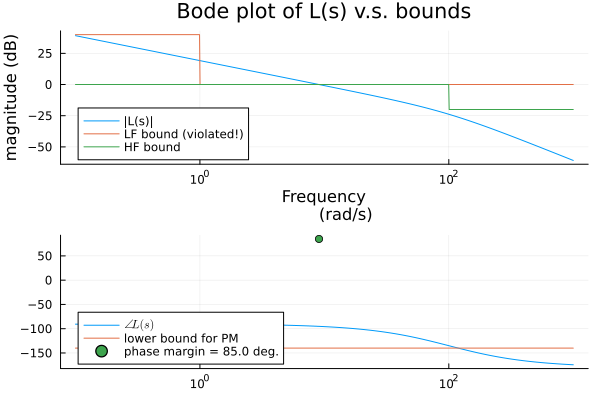

In [24]:
s = tf("s");
k = 1;
p = 100;
z = 0.011;
C = k*p*(s + z) / (z*(s + p));
P = 1 / (10*s^2 + 0.1*s);
lf = 1; #rad/s
lfb = 40;
hf = 100;
hfb = -20;
pm = 40;
lshape(C, P, lf, lfb, hf, hfb, pm)

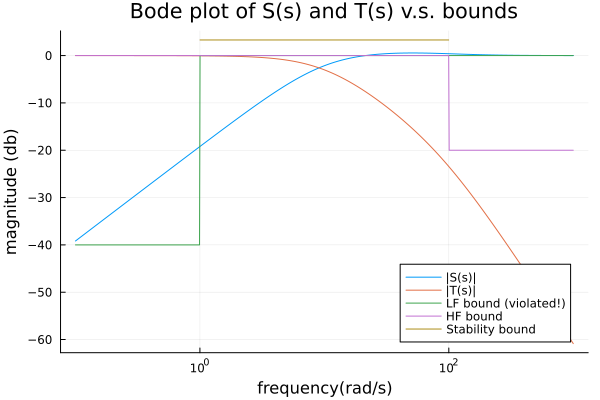

In [25]:
STplot(C, P, lf, lfb, hf, hfb, pm)

In [26]:
K = k_c*p_c/z_c

LoadError: UndefVarError: k_c not defined

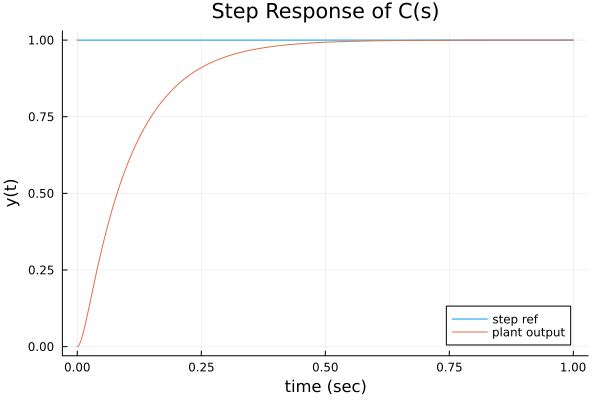

In [27]:
#Closed-loop step response
begin
    L = C*P
    T = minreal(L/(1+L))
    tvec1 = collect(Float64,0:0.001:1)
    y1,t1,x1 = step(T,tvec1)
    r1 = ones(size(t1))
    y1 = dropdims(y1, dims=1)
    plot(t1,r1, label="step ref")
    plot!(t1,y1, label="plant output",xlabel="time (sec)",ylabel="y(t)",title="Step Response of C(s)", legend=:bottomright)
end

In [28]:
function plot_response(sys, u, t, ampbnd, plottitle)
    u = reshape(u, (1,size(u)...))
    y, tout, x = lsim(sys, u, t, method=:zoh)
    t_idx = 150 # get rid of transient
    tout1 = tout[t_idx:end]
    y1 = y[t_idx:end]
    u1 = u[t_idx:end]
    
    pbnd = ampbnd * ones(size(tout1))
    nbnd = -ampbnd*ones(size(tout1))
    uplt = plot(tout1,u1, label= plottitle*" input",title=plottitle*" response")
    yplt = plot(tout1, y1, label = "plant output")
    plot!(tout1, pbnd, label = "positive bound")
    plot!(tout1, nbnd, label = "negative bound", xlabel="time (sec)", ylabel="y(t)")
    plot(uplt, yplt, layout=(2,1))
end

plot_response (generic function with 1 method)

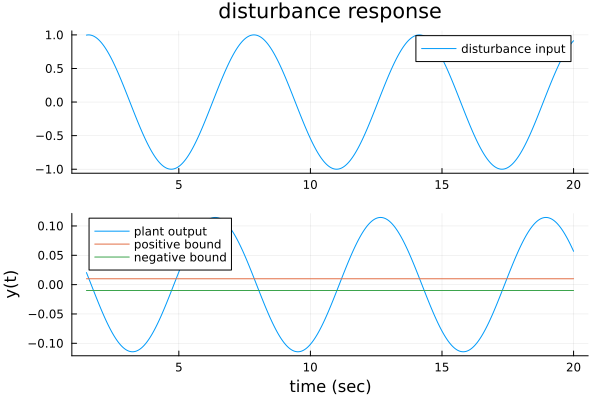

In [29]:
t_final = 20 #sec
df = 1 #freq (rad/s)
da = 1 #amplitude (Units)
begin
    S = minreal(1/(1+L))
    tvec2 = collect(Float64,0:0.01:t_final)
    u2 = da*sin.(df*tvec2)
    abnd = 0.01*da
    plot_response(S, u2, tvec2, abnd, "disturbance")
end

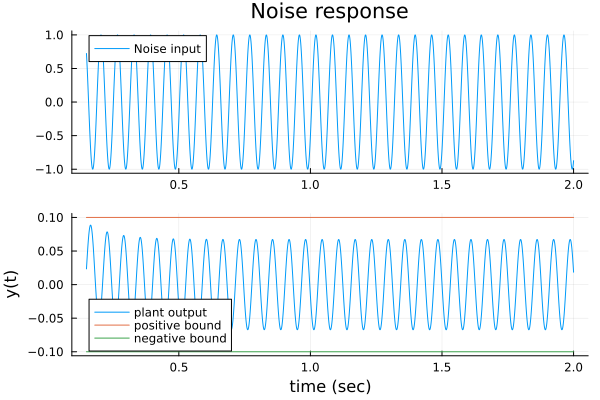

In [30]:
tn_final = 2;
nf = 100;
na = 1;
begin
    tvec3 = collect(Float64, 0:0.001:tn_final)
    u3 = na*sin.(nf*tvec3)
    nbnd = 0.1*na
    plot_response(T,u3,tvec3,nbnd,"Noise")
end
#Output should swing within ± 0.1